In [1]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.evaluation import precision_at_k as p_k_lfm
from lightfm.evaluation import auc_score
import gensim
import nltk
import re
import pymorphy2
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivanov.evgeny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivanov.evgeny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Описание задачи
В качестве данных для рекомендательной системы взята информация о количестве игрового времени пользователей с игровой платформы Steam с описаниями игр.

В файле steam-200k.csv представлена информация о пользователях и играх, которые он приобрел и играет, а также количество игрового времени в них.    
Файл steam.csv представляет собой описание игр, включающее название, дату релиза, жанр игр, разработчиков и так далее.   
Файл steam_description_data.csv содержит текстовое рекламное описание игр.     

Источники данных:   
https://www.kaggle.com/nikdavis/steam-store-games   
https://www.kaggle.com/tamber/steam-video-games

В качестве метрики качества классификации используется mean average precision@k.

Данная работа состоит из следующих частей:

1) Работа с данными   
2) Разделение данных на train/test   
3) Метрика качества рекомендаций   
4) Popular base подход   
5) FM   
6) Content base подход   
   6.1) Подготовка векторных представлений   
   6.2) Word2Vec   
   6.3) TF-IDF   
7) LightFM + text   
8) Сравнение рекомендаций   
9) Результаты

### 1) Работа с данными

In [2]:
# Данные взаимодействий
data = pd.read_csv("steam-200k.csv",names = ["user_id","item_name","play","play_hours","col_5"]) 
data.head()

,user_id,item_name,play,play_hours,col_5
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
# Оставляем только те игры, в которые реально играют
data_play = data[data.play == "play"]
data_play.head()

,user_id,item_name,play,play_hours,col_5
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
3,151603712,Fallout 4,play,87.0,0
5,151603712,Spore,play,14.9,0
7,151603712,Fallout New Vegas,play,12.1,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [4]:
# Данные с параметрами объетов рекомендаций
item_feature = pd.read_csv("steam.csv")
# Данные с описаниями игр - берем из них столбец с описаниями 
# и добавляем в наш набор
item_description = pd.read_csv("steam_description_data.csv")
item_feature["description"] = item_description.detailed_description
item_feature.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,description
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,Play the world's number 1 online action game. ...
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,One of the most popular online action games of...
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,Enlist in an intense brand of Axis vs. Allied ...
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,Enjoy fast-paced multiplayer gaming with Death...
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,Return to the Black Mesa Research Facility as ...


В данных по взаимодействиям и описаниях существуют разные наборы игр плюс необходимо привести к начальному виду названия игр.   
Определим общий набор игр, присутствующий во всех данных

In [5]:
# Названия игр из набора со взаимодействиями
item_names_data = [re.sub("[^A-Za-z0-9\s]", "", str(x).lower()).replace("  "," ").strip() for x in data_play.item_name.unique()]
# Названия игр из набора с описаниями
item_names_feat = [re.sub("[^A-Za-z0-9\s]", "", str(x).lower()).replace("  "," ").strip() for x in item_feature.name.unique()]
# Общий набор наименований игр
main_item = list(set(item_names_data) & set(item_names_feat))
# Исключенные игры из взаимодействий
del_item = list(set(item_names_data) - set(item_names_feat))

print(f"Количество оставленных игр: {len(main_item)}")
print(f"Количество убранных из рассмотрения игр: {len(del_item)}")

Количество оставленных игр: 2569
Количество убранных из рассмотрения игр: 1029


Преобразуем строковые признаки - уберем лишние символы, приведем к нижнему регистру.

In [6]:
# Преобразуем названия игр в данных о взаимодействиях и описаниях игр
data_play.item_name = data_play.item_name.apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s]", "", str(x).lower()).replace("  "," ").strip()) 
item_feature.name = item_feature.name.apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s]", "", str(x).lower()).replace("  "," ").strip()) 
# Преобразуем некоторые столбцы описаний игр
item_feature["description"] = item_feature["description"].apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s]", "", str(x).lower()).replace("  "," ").replace("\t","").replace("\n","").replace("\r","").strip())
item_feature["genres"] = item_feature["genres"].apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s\;]", "", str(x).lower()).replace("  "," ").strip())
item_feature["steamspy_tags"] = item_feature["steamspy_tags"].apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s\;]", "", str(x).lower()).replace(";"," ").strip())
item_feature["developer"] = item_feature["developer"].apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s\;]", "", str(x).lower()).replace(";"," ").strip())
item_feature["categories"] = item_feature["categories"].apply(lambda x:
                                                re.sub("[^A-Za-z0-9\s\;]", "", str(x).lower()).replace(";"," ").strip())
# Создадим из этих столбцов столбец с общим описанием игры
item_feature["descr_summary"] = item_feature["name"] + " " + item_feature["steamspy_tags"] + " " + item_feature["developer"] + " " + item_feature["categories"]
item_feature.head()

C:\Users\ivanov.evgeny\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,description,descr_summary
0,10,counterstrike,2000-11-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,action fps multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,play the worlds number 1 online action game en...,counterstrike action fps multiplayer valve mul...
1,20,team fortress classic,1999-04-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,action fps multiplayer,0,3318,633,277,62,5000000-10000000,3.99,one of the most popular online action games of...,team fortress classic action fps multiplayer v...
2,30,day of defeat,2003-05-01,1,valve,Valve,windows;mac;linux,0,multiplayer valve anticheat enabled,action,fps world war ii multiplayer,0,3416,398,187,34,5000000-10000000,3.99,enlist in an intense brand of axis vs allied t...,day of defeat fps world war ii multiplayer val...
3,40,deathmatch classic,2001-06-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,action fps multiplayer,0,1273,267,258,184,5000000-10000000,3.99,enjoy fastpaced multiplayer gaming with deathm...,deathmatch classic action fps multiplayer valv...
4,50,halflife opposing force,1999-11-01,1,gearbox software,Valve,windows;mac;linux,0,singleplayer multiplayer valve anticheat enabled,action,fps action scifi,0,5250,288,624,415,5000000-10000000,3.99,return to the black mesa research facility as ...,halflife opposing force fps action scifi gearb...


In [7]:
# Данные взаимодействий
data_play = data_play[data_play.item_name.apply(lambda x: x in main_item)]
# Данные с описаниями игр
item_feature = item_feature[item_feature.name.apply(lambda x: x in main_item)]

### 2) Разделение данных на train/test
Оставляем тех пользователей, у которых число взаимодействий более 8. В обучающую часть берем 80% взаимодействий, остальные - в валидационную

In [8]:
from sklearn.model_selection import train_test_split

user_id_test = set()
data_test = pd.DataFrame([])
data_train = pd.DataFrame([])
for user_id in tqdm_notebook(pd.unique(data_play["user_id"])):
    user_data = data_play[data_play['user_id']==user_id]
    if len(user_data) >= 8:
        train, test = train_test_split(user_data, test_size=0.2,random_state = 42)
        data_test = data_test.append(test)
        data_train = data_train.append(train)
        user_id_test.add(user_id)

Теперь сделаем так, чтобы игры присутствовали во всех выборках - как минимум, чтобы игры из test обязательно присутствовали в train. Также убираем игры, не попавшие в test и убираем пользователей, у которых в тестовой выборке оказалось меньше 2-х взаимодействий.

In [9]:
# Определяем игры из test, которых нет в train
train_name = set(data_train.item_name)
test_name = set(data_test.item_name)
game_not_in_train = test_name - train_name
while len(game_not_in_train):
    # Удаляем записи с отсутствующими в train играми из test
    #data_t = data_test.copy()
    data_test = data_test[data_test.item_name.apply(lambda x: x not in game_not_in_train)]

    # Определяем пользователей, у которых в test не менее двух взаимодействий - 
    # Остальных убираем из train и test
    cnt = Counter(data_test.user_id)
    lost_users = [x for x,y in cnt.items() if y>=2]
    data_train = data_train[data_train.user_id.apply(lambda x : x in lost_users)]
    data_test = data_test[data_test.user_id.apply(lambda x : x in lost_users)]
    # Обновляем список пользователей
    user_id_test = set(lost_users)
    # Пересчитываем множество непересекающихся игр
    train_name = set(data_train.item_name)
    test_name = set(data_test.item_name)
    game_not_in_train = test_name - train_name

In [10]:
# Проверяем, остались ли игры в test, которые не представлены в train
set(data_test.item_name) - set(data_train.item_name)

set()

In [11]:
# Смотрим на размерности полученных разбиений
print(data_train.shape[0],data_test.shape[0])

30475 8134


In [12]:
# Вернем отсортированный по индексам вид
data_train = data_train.sort_index()
data_test = data_test.sort_index()

Посмотрим на полученное разделение

In [13]:
data_train[data_train.user_id == 11403772].head()

,user_id,item_name,play,play_hours,col_5
28978,11403772,dota 2,play,2443.0,0
28980,11403772,team fortress 2,play,744.0,0
28984,11403772,fallout new vegas,play,115.0,0
28986,11403772,eve online,play,109.0,0
28988,11403772,counterstrike global offensive,play,94.0,0


In [14]:
data_test[data_test.user_id == 11403772].head()

,user_id,item_name,play,play_hours,col_5
29006,11403772,natural selection 2,play,33.0,0
29008,11403772,rust,play,30.0,0
29022,11403772,torchlight,play,24.0,0
29026,11403772,magic duels,play,22.0,0
29034,11403772,dirty bomb,play,19.2,0


### 3) Метрика качества рекомендаций
Определим метрику для анализа качества рекомендаций


In [15]:
def precision_at_k(y_true, y_pred, k = 10):
    '''
    Метрика precision@k 
    y_true - используемые игры
    y_pred - рекомендованные игры
    k - количество рассматриваемых рекомендаций
    '''
    result = 0.0
    if k < 1 or k > len(y_pred):
        return result
    else:
        y_pred = y_pred[:k]
    correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
    result = len(correct_indeces) / k
    return result

def average_precision_at_k(y_true, y_pred, k = 10):
    '''
    Метрика precision@k, усредненная по k от 1 до k - учитывает порядок релевантных вхождений
    y_true - используемые игры
    y_pred - рекомендованные игры
    k - количество рассматриваемых рекомендаций
    '''
    ap = 0
    for k_ind in range(1,k+1):
        ap += precision_at_k(y_true, y_pred,k_ind)
    return ap / k


def map_at_k(dict_pred, data, k = 10):
    '''
    Среднее average precision@k по пользователям из dict_pred
    dict_pred - словарь рекомендаций user_id:[item_rec_1,item_rec_2,...], item_rec-название игры
    data - dataframe взаимодействий user-item с реальными взаимодействиями
    '''
    sum_apk = 0
    for user, y_preds in dict_pred.items():
        sum_apk += average_precision_at_k(data[data['user_id']==user]['item_name'],y_preds,k)
    return sum_apk / len(dict_pred)


### 4) Popular base подход

Реализация подхода рекомендаций на основе наиболее популярных игр.   
Рейтинг считается исходя из кол-ва пользователей - owners, позитивных оценок - positive_ratings, общего числа оценок - positive_ratings + negative_ratings

In [16]:
item_feature.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,description,descr_summary
0,10,counterstrike,2000-11-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,action fps multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,play the worlds number 1 online action game en...,counterstrike action fps multiplayer valve mul...
1,20,team fortress classic,1999-04-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,action fps multiplayer,0,3318,633,277,62,5000000-10000000,3.99,one of the most popular online action games of...,team fortress classic action fps multiplayer v...
2,30,day of defeat,2003-05-01,1,valve,Valve,windows;mac;linux,0,multiplayer valve anticheat enabled,action,fps world war ii multiplayer,0,3416,398,187,34,5000000-10000000,3.99,enlist in an intense brand of axis vs allied t...,day of defeat fps world war ii multiplayer val...


Посчитаем среднее число пользователей, долю положительных оценок и общее число оценок

In [17]:
df_popular = item_feature.copy()

buf = df_popular['owners'].str.split(r"\-", expand=True).astype(int)

# Количество пользователей
df_popular['owners'] = (buf[0] + buf[1])/2
# Доля положительных оценок
df_popular['proc_positive_ratings'] = df_popular['positive_ratings'] / (df_popular['positive_ratings'] + df_popular['negative_ratings'])
df_popular['count_ratings'] = df_popular['positive_ratings'] + df_popular['negative_ratings']

#Сортируем по в
df_popular.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,description,descr_summary,proc_positive_ratings,count_ratings
0,10,counterstrike,2000-11-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,...,124534,3339,17612,317,15000000.0,7.19,play the worlds number 1 online action game en...,counterstrike action fps multiplayer valve mul...,0.973888,127873
1,20,team fortress classic,1999-04-01,1,valve,Valve,windows;mac;linux,0,multiplayer online multiplayer local multiplay...,action,...,3318,633,277,62,7500000.0,3.99,one of the most popular online action games of...,team fortress classic action fps multiplayer v...,0.839787,3951
2,30,day of defeat,2003-05-01,1,valve,Valve,windows;mac;linux,0,multiplayer valve anticheat enabled,action,...,3416,398,187,34,7500000.0,3.99,enlist in an intense brand of axis vs allied t...,day of defeat fps world war ii multiplayer val...,0.895648,3814


In [18]:
def weighted_rating(value_columns):
    '''
    Calculate the average rating by several values:
    sum( value[i] / max[i]) where i - index of value  
    '''
    sum = 0
    for v in value_columns:
        sum += v / v.max()
    return sum / len(value_columns)

# Считаем взвешенный рейтинг для игр
df_popular['weighted_rating'] = weighted_rating([df_popular['owners'], df_popular['proc_positive_ratings'], df_popular['count_ratings']])

In [19]:
# Сортируем по взвешенному рейтингу популярности
df_popular = df_popular.sort_values('weighted_rating', ascending=False)
df_popular.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,negative_ratings,average_playtime,median_playtime,owners,price,description,descr_summary,proc_positive_ratings,count_ratings,weighted_rating
25,730,counterstrike global offensive,2012-08-21,1,valve hidden path entertainment,Valve,windows;mac;linux,0,multiplayer steam achievements full controller...,action;free to play,...,402313,22494,6502,75000000.0,0.0,counterstrike global offensive cs go expands u...,counterstrike global offensive fps multiplayer...,0.867952,3046717,0.789317
22,570,dota 2,2013-07-09,1,valve,Valve,windows;mac;linux,0,multiplayer coop steam trading cards steam wor...,action;free to play;strategy,...,142079,23944,801,150000000.0,0.0,strongthe mostplayed game on steamstrongbrever...,dota 2 free to play moba strategy valve multip...,0.858710,1005586,0.729589
19,440,team fortress 2,2007-10-10,1,valve,Valve,windows;mac;linux,0,multiplayer crossplatform multiplayer steam ac...,action;free to play,...,34036,8495,623,35000000.0,0.0,h1the jungle inferno updateh1pa hrefhttpssteam...,team fortress 2 free to play multiplayer fps v...,0.938107,549915,0.450645


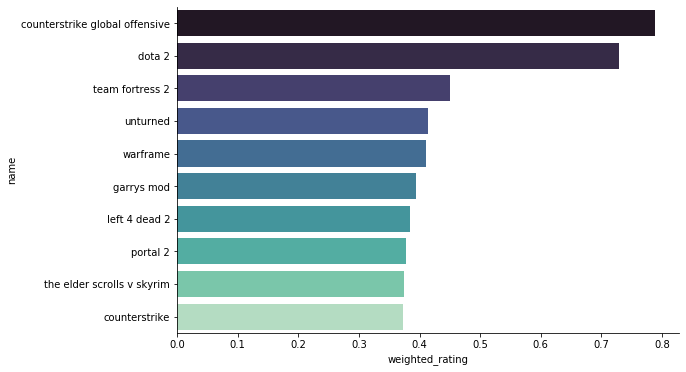

In [20]:
# Визуализируем наиболее популярные игры
fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = df_popular[['name','weighted_rating']].head(10),
            y = 'name',
            x = 'weighted_rating',
            palette = 'mako');
sns.despine();

In [21]:
def get_popular_pred_train(user_id_test):
    '''
    Расчет рекомендаций для train выборки 
    '''
    pred_popular = dict()
    for user in user_id_test:
        pred_popular[user] = df_popular['name'].head(10).tolist()
    return pred_popular

def get_popular_pred_test(user_id_test,data_train):
    '''
    Функция возвращает рекомендации для пользователя, за исключением тех позиций,
    которые уже есть в train этого пользователя
    '''
    pred_popular = dict()
    for user in user_id_test:
        user_games = data_train[data_train.user_id == user]["item_name"].tolist()
        pred_popular[user] = df_popular[df_popular.name.apply(lambda x: x not in user_games)]["name"].head(10).tolist()
    return pred_popular    
    

In [22]:
# Считаем предсказания для train/test
pred_popular_train = get_popular_pred_train(user_id_test)
pred_popular_test = get_popular_pred_test(user_id_test,data_train)

# Считаем метрику качества рекомендаций на train/test
mapk_train_pb = map_at_k(pred_popular_train,data_train)
mapk_test_pb = map_at_k(pred_popular_test,data_test)

print('Модель popular base')
print('MAP@k train %.2f' % (mapk_train_pb))
print('MAP@k test %.2f' % (mapk_test_pb)) 

Модель popular base
MAP@k train 0.31
MAP@k test 0.16


In [23]:
print("Предсказания для случайного пользователя")
pred_popular_test[151603712]

Предсказания для случайного пользователя


['counterstrike global offensive',
 'unturned',
 'warframe',
 'portal 2',
 'the elder scrolls v skyrim',
 'counterstrike',
 'terraria',
 'portal',
 'the witcher 3 wild hunt',
 'halflife 2']

In [24]:
print("Предсказания для случайного пользователя")
pred_popular_test[21061921]

Предсказания для случайного пользователя


['dota 2',
 'unturned',
 'warframe',
 'garrys mod',
 'counterstrike',
 'portal',
 'the witcher 3 wild hunt',
 'halflife 2',
 'euro truck simulator 2',
 'payday 2']

Видно, что рекомендации разные, так как в итоговой рекомендации убираются те, которые присутствуют в играх пользователя обучающей выборки.

### 5) FM
построим машину факторизации матрицы взаимодействий user-item при помощи библиотеки LightFM

In [25]:
# Таблица взаимодействий
data_train.head()

,user_id,item_name,play,play_hours,col_5
5,151603712,spore,play,14.9,0
7,151603712,fallout new vegas,play,12.1,0
9,151603712,left 4 dead 2,play,8.9,0
11,151603712,huniepop,play,8.5,0
13,151603712,path of exile,play,8.1,0


In [26]:
# Создаем матрицу users-items по набору train
user_item_data = pd.pivot_table(data_train, index='user_id', columns='item_name', values='play_hours')
# Заполняем NaN нулями
user_item_data = user_item_data.fillna(0)

In [27]:
# Смотрим на разреженность матрицы
mat_train = csr_matrix(user_item_data)
sparsity = float(len(mat_train.nonzero()[0]))
sparsity /= (mat_train.shape[0] * mat_train.shape[1])
sparsity *= 100
print(f'Sparsity: {sparsity:4.2f}%. This means that {sparsity:4.2f}% of the user-item ratings have a value.')

Sparsity: 0.91%. This means that 0.91% of the user-item ratings have a value.


In [28]:
# Размерность матрицы
mat_train.shape

(1449, 2318)

Определим функцию get_pred_FM для расчета предсказаний модели LigthFM

In [29]:
def get_pred_FM_train(model,interactions,item_features = None, k = 10):
    '''
    Функция возвращет словарь {user_id:топ-k рекомендаций} для всех пользователей
    model - модель LightFM
    interactions - sparse матрица взаимодействий
    item_features - sparse матрица описаний item
    k - число лучших рекомендаций    
    '''
    user_ids = list(user_item_data.index)
    item_names = list(user_item_data.columns)
    n_users, n_items = mat_train.shape
    res = dict()
    for user_ind in range(0,mat_train.shape[0]):
        scores = model.predict(user_ind,np.arange(n_items),item_features = item_features)
        top_k_ind = np.array(scores.argsort()[::-1][1:k+1],dtype = int).tolist()
        top_k_items = np.array(item_names)[top_k_ind].tolist()
        user_id = user_ids[user_ind]
        res[user_id] = top_k_items
    return res

In [30]:
def get_pred_FM_test(model,interactions,data_train,item_features = None, k = 10):
    '''
    Функция возвращет словарь {user_id:топ-k рекомендаций} для всех пользователей,
    исключая позиции, присутствующие в data_train играх пользователя
    model - модель LightFM
    interactions - sparse матрица взаимодействий
    item_features - sparse матрица описаний item
    k - число лучших рекомендаций    
    '''
    user_ids = list(user_item_data.index)
    item_names = list(user_item_data.columns)
    n_users, n_items = mat_train.shape
    res = dict()
    for user_ind in range(0,mat_train.shape[0]):
        user_id = user_ids[user_ind]
        user_games = data_train[data_train.user_id == user_id]["item_name"].tolist()
        scores = model.predict(user_ind,np.arange(n_items),item_features = item_features)
        # сортируем позиции
        top_ind = np.array(scores.argsort()[::-1],dtype = int).tolist()
        # названия игр
        top_items = np.array(item_names)[top_ind].tolist()
        # убираем игры, которые есть у пользователя в train и берем k первых позиций
        top_k_items = [x for x in top_items if x not in user_games][0:k]
        res[user_id] = top_k_items
    return res

In [70]:
# Создадим и обучим машину факторизации из библиотеки LigthFM:

model_fm = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.01,
                max_sampled=300,
                no_components=100,
                #item_alpha = 1e-6
                )

model_fm = model_fm.fit(mat_train,
                  epochs=100,
                  num_threads=16, verbose=True)


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


In [71]:
# Предсказания модели
pred_fm_train = get_pred_FM_train(model_fm,user_item_data,item_features = None, k = 10)
pred_fm_test = get_pred_FM_test(model_fm,user_item_data,data_train,item_features = None, k = 10)
# Считаем метрики точности на train/test на train
mapk_train_fm = map_at_k(pred_fm_train, data_train, 10)
mapk_test_fm = map_at_k(pred_fm_test, data_test, 10)

print('Модель FM')
print('MAP@k train %.2f' % (mapk_train_fm))
print('MAP@k test %.2f' % (mapk_test_fm))
#print('AUC: train %.2f' % (auc))

Модель FM
MAP@k train 0.54
MAP@k test 0.22


In [66]:
%%time
# Подбор гиперпараметров №1
learning_rate=[0.001,0.005,0.01]
no_components=[50,75,100]
params_list = [(x,y) for x in learning_rate for y in no_components]
best_model = LightFM(loss='warp',
                random_state=2016,
                )
best_score = 0
for lr,n_comp in tqdm_notebook(params_list):
    model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=lr,
                no_components = n_comp,
                max_sampled=300
                )
    
    model = model.fit(mat_train,
                      epochs=100,
                      num_threads=16, verbose=False)
    pred = get_pred_FM_test(model,user_item_data,data_train,item_features = None, k = 10)
    score = map_at_k(pred,data_test,10)
    if score>best_score:
        best_score = score
        best_model = model
    print(score,best_score, lr,n_comp)

0.17836663489872637 0.17836663489872637 0.001 50
0.17808926791328494 0.17836663489872637 0.001 75
0.17842860976919003 0.17842860976919003 0.001 100
0.1977047389003912 0.1977047389003912 0.005 50
0.20014057313746772 0.20014057313746772 0.005 75
0.19725727650158306 0.20014057313746772 0.005 100
0.21145247954254154 0.21145247954254154 0.01 50
0.21928179806544187 0.21928179806544187 0.01 75
0.2247894004622786 0.2247894004622786 0.01 100

Wall time: 9min 54s


In [69]:
%%time
# Подбор гиперпараметров №2
learning_rate= [0.02]
no_components=[50,75,100]
params_list = [(x,y) for x in learning_rate for y in no_components]
best_model = LightFM(loss='warp',
                random_state=2016,
                )
best_score = 0
for lr,n_comp in tqdm_notebook(params_list):
    model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=lr,
                no_components = n_comp,
                max_sampled=300
                )
    
    model = model.fit(mat_train,
                      epochs=100,
                      num_threads=16, verbose=False)
    pred = get_pred_FM_test(model,user_item_data,data_train,item_features = None, k = 10)
    score = map_at_k(pred,data_test,10)
    if score>best_score:
        best_score = score
        best_model = model
    print(score,best_score, lr,n_comp)

0.18680135178064816 0.18680135178064816 0.02 50
0.15099504858304083 0.18680135178064816 0.02 75
0.11899884430422783 0.18680135178064816 0.02 100

Wall time: 4min 24s


Оставляем параметры learning_rate=0.01 и no_components=100

### 6) Content base подход
Используем описание игр для создания векторов контента. В качестве векторизации рассмотрим два подхода построения эмбеддингов слов - word2vec и TF-IDF.   
В качестве описания берем столбец desc_all матрицы описаний игр.   
Эмбеддинг описания - сумма эмбеддингов входящих в него слов.

Определим функции косинусной близости векторов и выбора топ-к наиболее близких

In [33]:
def cosine_sim(a,b):
    '''
    Возвращает меру косинусной близости векторов a и b
    '''
    a = np.array(a)
    b = np.array(b)
    return a.dot(b)/np.linalg.norm(a)/np.linalg.norm(b)

def top_k(vec,item_embeddings,item_names,k):
    '''
    Возвращает список топ-k рекомендаций по косинусной близости для вектора описания vec
    vec - входной вектор эмбеддингов
    item_emb - матрица векторов всех эмбеддингов - описаний игр
    item_names - наименования эмбеддингов, соответсвтующие item_emb
    k - количество рекомендаций
    '''
    cos_sim_vectors = np.array([cosine_sim(vec,vec_i) for vec_i in item_embeddings]).reshape(-1)
    top_k_ind = cos_sim_vectors.argsort()[::-1][1:(k+1)].tolist()
    return [(x,y) for x,y in zip(list(item_names[top_k_ind]),cos_sim_vectors[top_k_ind])]

### 6.1) Подготовка векторных представлений

In [34]:
# Определяем стоп-слова
stop_words = set(stopwords.words("english"))
# Определяем лемматизацию
lemmatizer = WordNetLemmatizer()

In [35]:
# Для каждого item из user_item_data вытаскиваем описание и создаем общий словарь
sent_4_w2v = []
for item in list(user_item_data.columns):
    sent = item_feature.loc[item_feature.name==item,"descr_summary"].values.astype(str)[0]
    sent_4_w2v.append(sent)
# Пример описания игры
sent_4_w2v[0]

'0rbitalis simulation indie puzzle alan zucconi singleplayer steam achievements steam trading cards steam workshop steam cloud steam leaderboards includes level editor'

In [36]:
# Пример описания игры
sent_4_w2v[33]

'aaaaaa a reckless disregard for gravity action indie firstperson dejobaan games llc singleplayer steam achievements steam leaderboards'

In [37]:
# Токенизируем тексты, убираем стоп-слова и леммматизируем
def preprocessing_word(words_list, lemmatizer, stop_words):
    '''
    Функция убирает стоп-слова и лемматизирует слова из списка
    words_list - список слов
    lemmatizer - лемматизатор
    stop_words - множество стоп-слов
    '''
    words_list = [lemmatizer.lemmatize(word) for word in words_list if word not in stop_words]
    return words_list

In [38]:
# Корпус для word2vec
data_w2v = [preprocessing_word(x.split(),lemmatizer,stop_words) for x in sent_4_w2v]

# Корпус для TF-IDF
data_tfidf = [" ".join(preprocessing_word(x.split(),lemmatizer,stop_words)) for x in sent_4_w2v]

print("Элемент корпуса для обучения word2vec")
print(data_w2v[0])
print("Элемент корпуса для обучения tf-idf")
print(data_tfidf[0])

Элемент корпуса для обучения word2vec
['0rbitalis', 'simulation', 'indie', 'puzzle', 'alan', 'zucconi', 'singleplayer', 'steam', 'achievement', 'steam', 'trading', 'card', 'steam', 'workshop', 'steam', 'cloud', 'steam', 'leaderboards', 'includes', 'level', 'editor']
Элемент корпуса для обучения tf-idf
0rbitalis simulation indie puzzle alan zucconi singleplayer steam achievement steam trading card steam workshop steam cloud steam leaderboards includes level editor


### 6.2) Word2Vec

In [39]:
# Передаем список списков с токенизированными текстами и задаем словарь
wv_model = word2vec.Word2Vec(vector_size=100, workers=3,min_count=1)
wv_model.build_vocab(corpus_iterable = data_w2v)

In [40]:
# Обучаем word2vec
wv_model.train(data_w2v, total_examples=wv_model.corpus_count, epochs=200, report_delay=1)

(4225802, 7682200)

In [41]:
# Делаем матрицу с признаками - суммами эмбеддингов слов для описания каждого item
item_feat_w2v = np.array([sum([wv_model.wv[x] for x in data_w2v[i]]) for i in range(0,len(data_w2v))])

In [42]:
# Отнормируем вектора 
sc = StandardScaler()
item_feat_w2v_sc = sc.fit_transform(item_feat_w2v)
item_feat_w2v_sc_csr = csr_matrix(item_feat_w2v_sc)

Делаем предсказания по близости векторов - для каждого пользователя берутся топ-3 его игры по игровому времени.
Для каждой игры ищется 10 похожих, затем выбираются 10 тех, которые чаще всего встречаются в списке из суммарных 30 рекомендаций.

In [43]:
def get_content_rec_train(num_top_item = 3, k = 10, items_embedding = item_feat_w2v):
    '''
    Функция расчета рекомендаций user_id:[rec_items] для content base подхода.
    Для каждого пользователя берется num_top_item игр с наибольшим игровым временем. 
    Для каждой из этих игр ищется топ-k близких игр в пространстве эмбеддингов items_embedding
    Среди полученных num_top_item*k игр рекомендуются топ-k наиболее встречаемых
    '''
    dict_pred = dict()
    for user_id in tqdm_notebook(user_id_test):
        l = list()
        d = dict()
        for i in range(0, num_top_item):
            item_name = data_train[data_train.user_id == user_id].sort_values('play_hours', ascending=False)['item_name'].iloc[i]
            item_vector = items_embedding[user_item_data.columns == item_name]
            rec_items = top_k(item_vector,items_embedding,user_item_data.columns,k)
            # Обновляем суммарную близость для каждой рекомендации
            for item in rec_items:
                d[item[0]] = item[1] + d.get(item[0],0)

        d_sorted = sorted(d.items(), key=lambda x: x[1],  reverse=True)
        dict_pred[user_id] = [i[0] for i in d_sorted]
    return dict_pred


In [44]:
def top_k_test(vec,item_embeddings,user_games,item_names,k):
    '''
    Возвращает список топ-k рекомендаций по косинусной близости для вектора описания vec,
    исключая игры из train для каждого пользователя
    vec - входной вектор эмбеддингов
    item_emb - матрица векторов всех эмбеддингов - описаний игр
    item_names - наименования эмбеддингов, соответсвтующие item_emb
    k - количество рекомендаций
    '''
    cos_sim_vectors = np.array([cosine_sim(vec,vec_i) for vec_i in item_embeddings]).reshape(-1)
    top_ind = cos_sim_vectors.argsort()[::-1].tolist()
    top_items_without_train = [(x,y) for x,y in zip(list(item_names[top_ind]),cos_sim_vectors[top_ind]) if x not in user_games]
    return top_items_without_train[0:k]

In [45]:
def get_content_rec_test(num_top_item = 3, k = 10, items_embedding = item_feat_w2v, data_train = data_train):
    '''
    Функция расчета рекомендаций user_id:[rec_items] для content base подхода.
    Для каждого пользователя берется num_top_item игр с наибольшим игровым временем. 
    Для каждой из этих игр ищется топ-k близких игр в пространстве эмбеддингов items_embedding
    Среди полученных num_top_item*k игр рекомендуются топ-k наиболее встречаемых
    '''
    dict_pred = dict()
    for user_id in tqdm_notebook(user_id_test):
        l = list()
        d = dict()
        for i in range(0, num_top_item):
            item_name = data_train[data_train.user_id == user_id].sort_values('play_hours', ascending=False)['item_name'].iloc[i]
            item_vector = items_embedding[user_item_data.columns == item_name]
            user_games = data_train[data_train.user_id == user_id]["item_name"].tolist()
            rec_items = top_k_test(item_vector, items_embedding, user_games, user_item_data.columns,k)
            # Обновляем суммарную близость для каждой рекомендации
            for item in rec_items:
                d[item[0]] = item[1] + d.get(item[0],0)

        d_sorted = sorted(d.items(), key=lambda x: x[1],  reverse=True)
        dict_pred[user_id] = [i[0] for i in d_sorted][0:k]
    return dict_pred

In [46]:
%%time
# Делаем предсказания для word2vec представления описаний игр
pred_w2v_train = get_content_rec_train(num_top_item = 3, k = 10, items_embedding = item_feat_w2v)
pred_w2v_test = get_content_rec_test(num_top_item = 3, k = 10, items_embedding = item_feat_w2v, data_train = data_train)

# Считаем метрики точности на train/test 
mapk_train_w2v = map_at_k(pred_w2v_train, data_train, 10)
mapk_test_w2v = map_at_k(pred_w2v_test, data_test, 10)

print('Content_based Word2Vec')
print('MAP@k train %.2f' % (mapk_train_w2v))
print('MAP@k test %.2f' % (mapk_test_w2v))
#print('AUC: train %.2f' % (auc))


Content_based Word2Vec
MAP@k train 0.11
MAP@k test 0.05
Wall time: 4min 52s


### 6.3) TF-IDF

In [47]:
# Задаем векторизацию до трехграммных сочетаний и обучаем на наборе с обработанными уже текстами
vectorizer = TfidfVectorizer(ngram_range = (1,3),max_features=10000)
item_feat_tfidf_csr = vectorizer.fit_transform(data_tfidf)
item_feat_tfidf = item_feat_tfidf_csr.toarray()

In [48]:
# Делаем предсказания для tf-idf представления описаний игр
pred_tfidf_train = get_content_rec_train(num_top_item = 3, k = 10, items_embedding = item_feat_tfidf)
pred_tfidf_test = get_content_rec_test(num_top_item = 3, k = 10, items_embedding = item_feat_tfidf, data_train = data_train)
# Считаем метрики точности на train/test 
mapk_train_tfidf = map_at_k(pred_tfidf_train, data_train, 10)
mapk_test_tfidf = map_at_k(pred_tfidf_test, data_test, 10)

print('Content_based TF-IDF')
print('MAP@k train %.2f' % (mapk_train_tfidf))
print('MAP@k test %.2f' % (mapk_test_tfidf))


Content_based TF-IDF
MAP@k train 0.11
MAP@k test 0.05


Примеры рекомендаций по разным методам векторизации описаний

In [49]:
print("Рекомендации по TF-IDF:")
pred_tfidf_test[95084569]

Рекомендации по TF-IDF:


['depth',
 'team fortress 2',
 'labyronia rpg',
 'neverending nightmares',
 'influent',
 'just get through',
 'the banner saga',
 'shadow warrior',
 'boo bunny plague',
 'dex']

In [50]:
print("Рекомендации по Word2Vec:")
pred_w2v_test[95084569]

Рекомендации по Word2Vec:


['killing floor 2',
 'team fortress 2',
 'garrys mod',
 'orion prelude',
 'depth',
 'dying light',
 'slender the arrival',
 'boid',
 'codename cure',
 'neverending nightmares']

### 7). LightFM + text
Добавим в модель факторизации эмбеддинги описания игр, полученных с помощью Word2Vec и TF-IDF

LightFM + Word2Vec:

In [72]:

model_fm_w2v = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.01,
                max_sampled=300,
                no_components = 100
                )

model_fm_w2v = model_fm_w2v.fit(mat_train,
                  item_features = item_feat_w2v_sc_csr,
                  epochs=100,
                  num_threads=16, verbose=True)


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [46:06<00:00, 27.66s/it]


In [73]:
# Предсказания модели
pred_fm_w2v_train = get_pred_FM_train(model_fm_w2v,user_item_data,item_features = item_feat_w2v_sc_csr, k = 10)
pred_fm_w2v_test = get_pred_FM_test(model_fm_w2v,user_item_data,data_train,item_features = item_feat_w2v_sc_csr, k = 10)

mapk_train_fm_w2v = map_at_k(pred_fm_w2v_train, data_train, 10)
mapk_test_fm_w2v = map_at_k(pred_fm_w2v_test, data_test, 10)

print('Модель FM + w2v')
print('MAP@k train %.2f' % (mapk_train_fm_w2v))
print('MAP@k test %.2f' % (mapk_test_fm_w2v))


Модель FM + w2v
MAP@k train 0.51
MAP@k test 0.12


LightFM + TF-IDF:

In [74]:
 model_fm_tfidf = LightFM(loss='warp',
                random_state = 2016,
                learning_rate = 0.01,
                max_sampled = 300,
                no_components = 100
                )

model_fm_tfidf = model_fm_tfidf.fit(mat_train,
                  item_features = item_feat_tfidf_csr,
                  epochs=100,
                  num_threads=16, verbose=True)


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [25:19<00:00, 15.19s/it]


In [75]:
# Предсказания модели
pred_fm_tfidf_train = get_pred_FM_train(model_fm_tfidf,user_item_data,item_features = item_feat_tfidf_csr, k = 10)
pred_fm_tfidf_test = get_pred_FM_test(model_fm_tfidf,user_item_data,data_train,item_features = item_feat_tfidf_csr, k = 10)

# Считаем метрики точности на train/test
mapk_train_fm_tfidf = map_at_k(pred_fm_tfidf_train, data_train, 10)
mapk_test_fm_tfidf = map_at_k(pred_fm_tfidf_test, data_test, 10)

print('Модель FM + TF-IDF')
print('MAP@k train %.2f' % (mapk_train_fm_tfidf))
print('MAP@k test %.2f' % (mapk_test_fm_tfidf))


Модель FM + TF-IDF
MAP@k train 0.66
MAP@k test 0.22


In [55]:
data_train.user_id.unique()[:10]

array([151603712,  59945701,  53875128, 126340495,  97298878,  92107940,
        48845802, 226212066,  65117175,  11373749], dtype=int64)

### 8). Сравнение рекомендаций

In [76]:
# Пользователь
user_id = 151603712
# Соберем таблицу с поведением пользователя и рекомендациями, полученными различными методами
rec_df = pd.DataFrame()
rec_df["pop_base"] = pred_popular_test[user_id]
rec_df["w2v"] = pred_w2v_test[user_id]
rec_df["tf_idf"] = pred_tfidf_test[user_id]
rec_df["FM"] = pred_fm_test[user_id]
rec_df["FM_w2v"] = pred_fm_w2v_test[user_id]
rec_df["FM_tfidf"] = pred_fm_tfidf_test[user_id]
user_test = data_test[data_test.user_id == user_id].sort_values('play_hours', ascending=False)['item_name'].values.tolist()
user_game_test = np.empty(10,dtype = object)
user_game_test[0:len(user_test)] = user_test
rec_df["user_test_games"] = user_game_test
rec_df["user_train_games"] = data_train[data_train.user_id == user_id].sort_values('play_hours', ascending=False)['item_name'].iloc[0:10].values.tolist()
rec_df.head(11)

,pop_base,w2v,tf_idf,FM,FM_w2v,FM_tfidf,user_test_games,user_train_games
0,counterstrike global offensive,left 4 dead,left 4 dead,the elder scrolls v skyrim,portal 2,the elder scrolls v skyrim,the elder scrolls v skyrim,spore
1,unturned,killing floor,spore creepy cute parts pack,counterstrike global offensive,the witcher 3 wild hunt,unturned,fallout 4,fallout new vegas
2,warframe,halflife 2,counterstrike source,terraria,block n load,portal 2,left 4 dead,left 4 dead 2
3,portal 2,killing floor 2,halflife 2 episode one,borderlands 2,counterstrike global offensive,terraria,grand theft auto iv,huniepop
4,the elder scrolls v skyrim,portal 2,halflife 2 episode two,portal 2,mad max,borderlands 2,eldevin,path of exile
5,counterstrike,orion prelude,portal 2,warframe,unturned,counterstrike global offensive,None,poly bridge
6,terraria,sniper elite nazi zombie army,hoard,sid meiers civilization v,the witcher 2 assassins of kings enhanced edition,fallout 4,None,team fortress 2
7,portal,depth,depth,unturned,the elder scrolls v skyrim,planetside 2,None,tomb raider
8,the witcher 3 wild hunt,halflife 2 episode two,gas guzzlers extreme,payday 2,ark survival evolved,the witcher 2 assassins of kings enhanced edition,None,the banner saga
9,halflife 2,dying light,blockscape,torchlight ii,8bitmmo,portal,None,bioshock infinite


In [77]:
# Соберем таблицу сравнения метрик качества рекомендательных систем
models_df = pd.DataFrame(columns=["MAP@k train","MAP@k test"])
models_df.loc["popular base"] = [mapk_train_pb,mapk_test_pb]
models_df.loc["word2vec"] = [mapk_train_w2v,mapk_test_w2v]
models_df.loc["tf-idf"] = [mapk_train_tfidf,mapk_test_tfidf]
models_df.loc["FM"] = [mapk_train_fm,mapk_test_fm]
models_df.loc["FM + word2vec"] = [mapk_train_fm_w2v,mapk_test_fm_w2v]
models_df.loc["FM + tf-idf"] = [mapk_train_fm_tfidf,mapk_test_fm_tfidf]
models_df.head(10)


,MAP@k train,MAP@k test
popular base,0.312138,0.164455
word2vec,0.107700,0.048736
tf-idf,0.114937,0.046048
FM,0.536914,0.224789
FM + word2vec,0.509120,0.119303
FM + tf-idf,0.657007,0.218801


### 9). Результаты

Опробированы несколько вариантов рекомендательных систем. Лучшей по метрике точности на валидационной выборке оказался метод факторизации из LightFM на основе матрицы взаимодействий, затем уже LightFM + TF-IDF представления описаний игр, затем уже popar base подход. 

При этом подмешивание информации об описаниях игр не повысило качество модели LightFM, а в случае с эмбеддингами описаний, полученных с помощью word2vec, сильно понизило качество рекомендаций.

Рекомендации по схожести наиболее используемых игр, дают достаточно неплохие рекомендации с точки зрения смысловой схожести игр. Однако, это, видимо, не является определяющим в выборе игр пользователями. Это становится понятно при просмотре списков игр - в них часто нет схожести между собой.

Повысить качество модели можно, построив на основе новых признаков модель градиентного бустинга как регрессию на игровое время. В качестве признаков можно взять скалярное произведение векторов user и item из LightFM, LightFM+text, частотности игр, совстречаемости игр в наборах у игроков. 